# Inverting Earthquake Focal Mechanism using Automatic Differentiation

In [1]:
from torch import nn
import torch.nn.functional as F
import torch
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
from dataclasses import dataclass
import copy

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Build forward model to calculate polarity

In [2]:
class FocalMechanism(nn.Module):
    """
    get radiation pattern given focal mechanism, take-off angle and azimuth angle
    reference: Aki and Richards-2002-p.108-110
    Args:
        fm: focal mechanism, [strike, dip, rake] in degree
        takeoff: take-off angle in degree, zero points to downward, np.array
        azimuth: azimuth angle in degree, zero points to north, np.array
        type: 'P' or 'SH' or 'SV'
    """
    def __init__(self, strike = [0], dip = [0], rake = [0], scale=False, dtype=torch.float32):
        super().__init__()
        self.num_event = len(strike)
        self.strike = nn.Parameter(torch.tensor(strike, dtype=dtype).unsqueeze(-1))
        self.dip = nn.Parameter(torch.tensor(dip, dtype=dtype).unsqueeze(-1))
        self.rake = nn.Parameter(torch.tensor(rake, dtype=dtype).unsqueeze(-1))
        self.scale = scale
        if self.scale:
            self.w = nn.Parameter(torch.zeros(self.num_event, dtype=dtype).unsqueeze(-1))
            # self.w = nn.Parameter(torch.ones(self.num_event, dtype=dtype).unsqueeze(-1))
    
    def forward(self, takeoff, azimuth, phase):

        inc = torch.deg2rad(takeoff)
        azi = torch.deg2rad(azimuth)
        strike = torch.deg2rad(self.strike)
        dip = torch.deg2rad(self.dip)
        rake = torch.deg2rad(self.rake)

        si = torch.sin(inc)
        ci = torch.cos(inc)
        s2i = torch.sin(2 * inc)
        c2i = torch.cos(2 * inc)

        sd = torch.sin(dip)
        cd = torch.cos(dip)
        s2d = torch.sin(2 * dip)
        c2d = torch.cos(2 * dip)
        sr = torch.sin(rake)
        cr = torch.cos(rake)
        sas = torch.sin(azi - strike)
        cas = torch.cos(azi - strike)

        s2as = 2 * sas * cas
        c2as = cas**2 - sas**2

        polarity_p = (
            -cas * cd * cr * s2i
            + cr * s2as * sd * si**2
            + c2d * s2i * sas * sr
            + s2d * (ci**2 + (-1) * sas**2 * si**2) * sr
        )
        polarity_sv = (
            -c2i * cas * cd * cr
            + (1 / 2) * cr * s2as * s2i * sd
            + c2d * c2i * sas * sr
            + (-1 / 2) * s2d * s2i * (1 + sas**2) * sr
        )
        polarity = torch.stack([polarity_p, polarity_sv], dim=-1)
        # polarity_sh = (
        #     cd * ci * cr * sas
        #     + c2as * cr * sd * si
        #     + c2d * cas * ci * sr
        #     + (-1 / 2) * s2as * s2d * si * sr
        # )
        # polarity = torch.stack([polarity_p, polarity_sv, polarity_sh], dim=-1)
        polarity = torch.sum(polarity * phase, dim=(-1))
        if self.scale and self.training:
            # polarity *= (torch.abs(self.w) + 1.0)
            # polarity *= (torch.exp(-self.w) + 1.0)
            # polarity *= (F.softplus(self.w) + 1.0)
            polarity *= (F.elu(self.w) + 2.0)

        return polarity

## Generate synthetic data

In [3]:
def generate_data(strike, dip, rake):
    with torch.no_grad():
        model = FocalMechanism(strike=strike, dip=dip, rake=rake, scale=False)
        takeoff_angles = []
        azimuths = []
        phase_types = []
        for event in range(len(strike)):
            takeoff_angle = torch.from_numpy(np.linspace(0, 180, 50))
            azimuth = torch.from_numpy(np.linspace(0, 360, 50))
            takeoff_angle, azimuth = torch.meshgrid(takeoff_angle, azimuth, indexing="ij")
            takeoff_angle = takeoff_angle.flatten()
            azimuth = azimuth.flatten()
            phase_type = torch.zeros([len(takeoff_angle), 2], dtype=torch.float32)
            phase_type[:, 0] = 1
            
            takeoff_angles.append(takeoff_angle)
            azimuths.append(azimuth)
            phase_types.append(phase_type)

        takeoff_angle = torch.stack(takeoff_angles, dim=0)
        azimuth = torch.stack(azimuths, dim=0)
        phase_type = torch.stack(phase_types, dim=0)
        polarity = model(takeoff_angle, azimuth, phase=phase_type)
        polarity = torch.sign(polarity)

    data = {"phase_polarity": polarity, "phase_type": phase_type, "takeoff_angle": takeoff_angle, "azimuth": azimuth}
    return data

In [4]:
strike = [45, 30]
dip = [90, 80]
rake = [0, 60]
data = generate_data(strike, dip, rake)

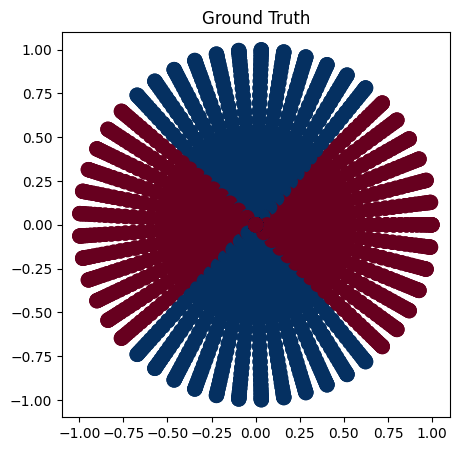

In [5]:
event_index = 0
x = torch.cos(torch.deg2rad(data["azimuth"][event_index]))*torch.sin(torch.deg2rad(data["takeoff_angle"][event_index]))
y = torch.sin(torch.deg2rad(data["azimuth"][event_index]))*torch.sin(torch.deg2rad(data["takeoff_angle"][event_index]))
c = data["phase_polarity"][event_index]
fig, ax = plt.subplots(1, 1, squeeze=False, figsize=(5, 5))    
ax[0, 0].scatter(x, y, s=100, c = c, cmap="RdBu")
ax[0, 0].set_title("Ground Truth")
plt.savefig("data.png")

## Invert Focal Mechanism

In [6]:
def solve_bfgs(data, model, args=None):

    takeoff_angle = data["takeoff_angle"]
    azimuth = data["azimuth"]
    phase_type = data["phase_type"]
    polarity = data["phase_polarity"]
    gamma = args.gamma

    optimizer = optim.LBFGS(params=model.parameters(), max_iter=1000, line_search_fn="strong_wolfe")

    model.train()

    def closure():
        optimizer.zero_grad()
        output = model(takeoff_angle, azimuth, phase_type)
        # loss = F.mse_loss(output, polarity)
        # loss = torch.mean(torch.relu(1.0 - polarity * output)) + gamma*torch.mean(torch.abs(model.w))
        loss = torch.mean(torch.relu(1.0 - polarity * output)) + gamma*torch.mean(model.w**2)
        # loss = torch.mean(torch.relu(1.0 - polarity * output)**2) + gamma*torch.mean(model.w**2)
        loss.backward()
        return loss

    optimizer.step(closure)

    return model

In [7]:
def solve_sgd(data, model, args=None):

    takeoff_angle = data["takeoff_angle"]
    azimuth = data["azimuth"]
    phase_type = data["phase_type"]
    polarity = data["phase_polarity"]
    gamma = args.gamma

    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    # optimizer = optim.Adagrad(model.parameters(), lr=args.lr)
    optimizer = optim.RMSprop(model.parameters(), lr=args.lr)

    model.train()
    min_loss = 1e10
    pbar = tqdm(range(args.epoch), desc="Training")
    for epoch in pbar:
        output = model(takeoff_angle, azimuth, phase_type)
        # loss = torch.mean(torch.relu(1.0 - polarity * output)) + gamma*torch.mean(torch.abs(model.w))
        loss = torch.mean(torch.relu(1.0 - polarity * output)) + gamma*torch.mean(model.w**2)
        if loss < min_loss:
            min_loss = loss
            best_model = copy.deepcopy(model)
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item())
    
    return best_model
    

In [8]:
strike0 = [0.1, 0.1]
dip0 = [0.1, 0.1]
rake0 = [0.1, 0.1]
num_events = len(strike0)
model = FocalMechanism(strike=strike0, dip=dip0, rake=rake0, scale=True)
@dataclass
class Args:
    epoch: int = 1000
    lr: float = 1.0
    gamma: float = 0.00001
args = Args()
model = solve_bfgs(data, model, args)
# model = solve_sgd(data, model, args)
for i in range(num_events):
    print(f"strike: {model.strike[i].item():.1f} dip: {model.dip[i].item():.1f}, rake: {model.rake[i].item():.1f}, w: {model.w[i].item():.6f}")

strike: 45.0 dip: 90.0, rake: 0.0, w: 49.522991
strike: 103.3 dip: -31.2, rake: -19.3, w: 32.632763


In [9]:
pred = model(data["takeoff_angle"], data["azimuth"], data["phase_type"]).detach().numpy()
loss = torch.relu(1.0 - data['phase_polarity'] * pred)
loss = torch.clamp(1 - data['phase_polarity'] * pred, min=0)
print(f"Supports: {torch.count_nonzero(loss, dim=-1)}")
print(f"Zeros: {torch.count_nonzero(loss == 0, dim=-1)}")
print(f"Loss: {torch.mean(loss)}")

Supports: tensor([409, 128])
Zeros: tensor([2091, 2372])
Loss: 0.07035889619321717


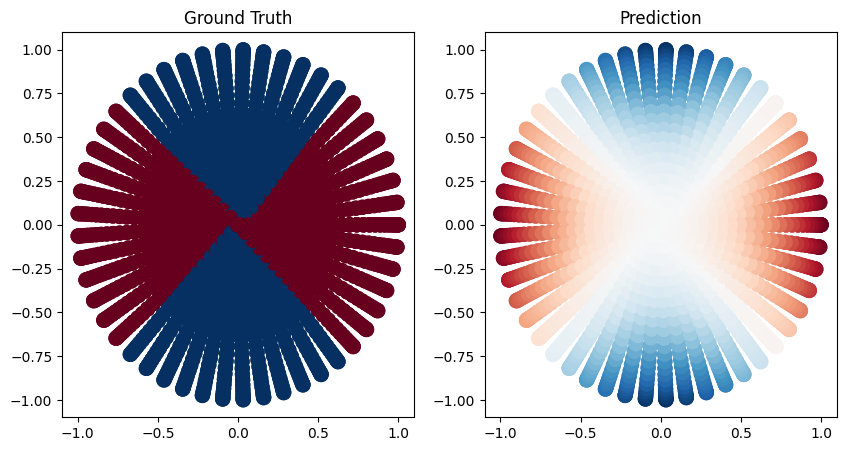

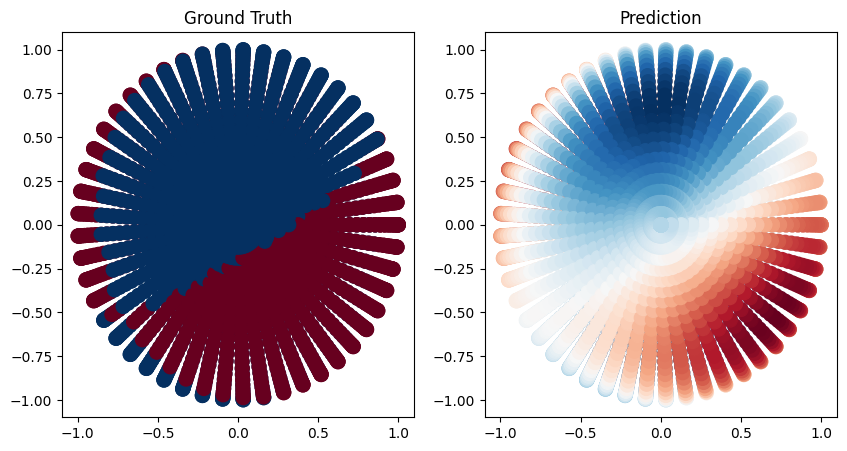

In [10]:
for event_index in range(num_events):
    x = torch.cos(torch.deg2rad(data["azimuth"][event_index]))*torch.sin(torch.deg2rad(data["takeoff_angle"][event_index]))
    y = torch.sin(torch.deg2rad(data["azimuth"][event_index]))*torch.sin(torch.deg2rad(data["takeoff_angle"][event_index]))
    c = data["phase_polarity"][event_index]
    fig, ax = plt.subplots(1, 2, squeeze=False, figsize=(10, 5))    
    ax[0, 0].scatter(x, y, s=100, c = c, cmap="RdBu")
    ax[0, 0].set_title("Ground Truth")
    ax[0, 1].scatter(x, y, s=100, c = pred[event_index], cmap="RdBu")
    ax[0, 1].set_title("Prediction")
    plt.savefig("result.png")
